In [15]:
!pip install matplotlib-venn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from google.colab import drive
drive.mount('/content/gdrive')
from numpy import array
from numpy import asarray
from numpy import zeros

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [18]:
BATCH_SIZE = 64
NUM_SENTENCES = 20000
MAX_SENTENCE_LENGTH = 50
MAX_WORDS_COUNT = 20000
EMBEDDING_SIZE = 100
EPOCHS = 20
LSTM_NODES =256

In [19]:
Input_list = [] 
Output_list = []  
Output_input_list = []  
 
count = 0
for line in open(r'/content/gdrive/My Drive/german_sample.txt', encoding="utf-8"):
    count += 1

    if count > NUM_SENTENCES:
        break

    if '\t' not in line:
        continue

    input_sentence, output = line.rstrip().split('\t')

    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output

    Input_list.append(input_sentence)
    Output_list.append(output_sentence)
    Output_input_list.append(output_sentence_input)

print("Number of input samples for encoder:", len(Input_list))
print("Number of output samples for encoder:", len(Output_list))
print("Number of input samples for decoder:", len(Output_input_list))

Number of input samples for encoder: 20000
Number of output samples for encoder: 20000
Number of input samples for decoder: 20000


In [ ]:
print(Input_list[205])
print(Output_list[205])
print(Output_input_list[205])

Help us.
Hilf uns! <eos>
<sos> Hilf uns!


In [ ]:
token_input = Tokenizer(num_words = MAX_WORDS_COUNT)
token_input.fit_on_texts(Input_list)
input_integer_seq = token_input.texts_to_sequences(Input_list)

input_word_index = token_input.word_index
print('Number of unique words in input list: %s' % len(input_word_index))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of the longest sentence in input list: %g" % max_input_len)

Number of unique words in input list: 3552
Length of the longest sentence in input list: 6


In [ ]:
token_output = Tokenizer(num_words = MAX_WORDS_COUNT, filters='')
token_output.fit_on_texts(Output_list + Output_input_list)
output_integer_seq = token_output.texts_to_sequences(Output_list)
output_input_integer_seq = token_output.texts_to_sequences(Output_input_list)

output_word_index = token_output.word_index
print('Number of unique words in the output list: %s' % len(output_word_index))

num_words_output = len(output_word_index) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of the longest sentence in output list: %g" % max_out_len)

Number of unique words in the output list: 8090
Length of the longest sentence in output list: 11


In [ ]:
encoder_padded_input_sequence = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("Checking shape of padded input sequence for encoder:", encoder_padded_input_sequence.shape)
print("Padded input sequence for encoder at index [205]:", encoder_padded_input_sequence[205])

Checking shape of padded input sequence for encoder: (20000, 6)
Padded input sequence for encoder at index [205]: [ 0  0  0  0 63 57]


In [ ]:
print(input_word_index["help"])
print(input_word_index["us"])

63
57


In [ ]:
decoder_padded_input_sequence = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("Checking shape of padded input sequence for decoder:", decoder_padded_input_sequence.shape)
print("Padded input sequence for decoder at index [205]:", decoder_padded_input_sequence[205])

Checking shape of padded input sequence for decoder: (20000, 11)
Padded input sequence for decoder at index [205]: [  2 398 399   0   0   0   0   0   0   0   0]


In [ ]:
print(output_word_index["<sos>"])
print(output_word_index["hilf"])
print(output_word_index["uns!"])

2
398
399


In [ ]:
decoder_padded_output_sequence=pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("Checking shape of padded output sequence for decoder:", decoder_padded_output_sequence.shape)
print("Padded output sequence for decoder at index [205]", decoder_padded_output_sequence[205])


Checking shape of padded output sequence for decoder: (20000, 11)
Padded output sequence for decoder at index [205] [398 399   1   0   0   0   0   0   0   0   0]


In [ ]:
word_embed_dict = dict()

globvector  = open(r'/content/gdrive/My Drive/glove.6B.100d.txt', encoding="utf8")

for line in globvector:
    records = line.split()
    word = records[0]
    vector_dim  = asarray(records[1:], dtype='float32')
    word_embed_dict[word] = vector_dim 
globvector.close()

In [ ]:
words_count = min(MAX_WORDS_COUNT, len(input_word_index) + 1)
embedding_matrix = zeros((words_count, EMBEDDING_SIZE))
for word, index in input_word_index.items():
    embedding_vector = word_embed_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
print(word_embed_dict["help"])

[-0.2272     0.41578    0.035985  -0.22895    0.13481   -0.12407
 -0.56653   -0.32096    0.16223   -0.024273  -0.033683  -0.4281
 -0.043623  -0.18682   -0.29002   -0.2464     0.51505   -0.27678
 -0.97691    0.6466    -0.2955    -0.34955    0.0085932  0.17147
 -0.24341    0.018099  -0.57991   -0.68634    0.29723   -0.19539
 -0.39285    0.55418   -0.11855    0.40271   -0.24441    0.13792
  0.14396    0.15116    0.19257   -0.095074  -0.59663   -0.27685
 -0.43814   -0.98947   -0.52515    0.52006   -0.4445    -0.23366
 -0.21019   -0.9059    -0.78404    0.11093    0.09208    1.2145
  0.52067   -2.4821    -0.17693   -0.94136    1.8578     0.17312
 -0.32761    0.45067   -0.092353   0.11201    0.50869    0.52743
 -0.075203   0.73518    0.40716   -0.74727    0.60342   -0.69189
 -0.56087   -0.87252    0.56949    0.35642   -0.25138    0.37888
 -0.68022    0.19444    0.92435    0.5161    -0.62632   -0.16946
 -1.825      0.23406    0.31977    0.76773   -0.83824   -0.38335
 -0.037695  -0.053895   0.1

In [ ]:
print(embedding_matrix[63])

[-0.2272      0.41578001  0.035985   -0.22894999  0.13481    -0.12407
 -0.56652999 -0.32095999  0.16223    -0.024273   -0.033683   -0.42809999
 -0.043623   -0.18682    -0.29001999 -0.2464      0.51504999 -0.27678001
 -0.97691     0.64660001 -0.29550001 -0.34955001  0.0085932   0.17147
 -0.24341001  0.018099   -0.57990998 -0.68633997  0.29723001 -0.19539
 -0.39285001  0.55418003 -0.11855     0.40270999 -0.24440999  0.13792001
  0.14396     0.15116     0.19257    -0.095074   -0.59662998 -0.27684999
 -0.43814    -0.98947001 -0.52515     0.52006    -0.4445     -0.23366
 -0.21019    -0.9059     -0.78403997  0.11093     0.09208     1.21449995
  0.52067    -2.48210001 -0.17693    -0.94136     1.85780001  0.17312001
 -0.32760999  0.45067    -0.092353    0.11201     0.50869     0.52743
 -0.075203    0.73518002  0.40716001 -0.74726999  0.60342002 -0.69189
 -0.56086999 -0.87252003  0.56949002  0.35642001 -0.25138     0.37887999
 -0.68022001  0.19444001  0.92435002  0.51609999 -0.62632    -0.16946

In [ ]:
embedding_layer = Embedding(words_count, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

In [ ]:
decoder_target_array = np.zeros((
        len(Input_list),
        max_out_len,
        num_words_output
    ),
    dtype='float32')

In [ ]:
decoder_target_array.shape

(20000, 11, 8091)

In [ ]:
for i,e in enumerate(decoder_padded_output_sequence):
    for t, word in enumerate(e):
        decoder_target_array[i, t, word] = 1

In [ ]:
encoder_in_placeholder = Input(shape=(max_input_len,))
x = embedding_layer(encoder_in_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

In [ ]:
decoder_in_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_in_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

In [ ]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
model1 = Model([encoder_in_placeholder,
  decoder_in_placeholder], decoder_outputs)
model1.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
r = model1.fit(
    [encoder_padded_input_sequence, decoder_padded_input_sequence],
    decoder_target_array,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,)

Epoch 1/20
282/282 [==============================] - 119s 408ms/step - loss: 2.1464 - accuracy: 0.7051 - val_loss: 2.1124 - val_accuracy: 0.7076
Epoch 2/20
282/282 [==============================] - 113s 402ms/step - loss: 1.5802 - accuracy: 0.7691 - val_loss: 1.8903 - val_accuracy: 0.7367
Epoch 3/20
282/282 [==============================] - 114s 404ms/step - loss: 1.3791 - accuracy: 0.7945 - val_loss: 1.7517 - val_accuracy: 0.7570
Epoch 4/20
282/282 [==============================] - 115s 410ms/step - loss: 1.2470 - accuracy: 0.8117 - val_loss: 1.6664 - val_accuracy: 0.7681
Epoch 5/20
282/282 [==============================] - 116s 413ms/step - loss: 1.1473 - accuracy: 0.8238 - val_loss: 1.6102 - val_accuracy: 0.7757
Epoch 6/20
282/282 [==============================] - 115s 410ms/step - loss: 1.0684 - accuracy: 0.8343 - val_loss: 1.5585 - val_accuracy: 0.7810
Epoch 7/20
282/282 [==============================] - 114s 404ms/step - loss: 1.0033 - accuracy: 0.8432 - val_loss: 1.5324 -

In [ ]:
encoder_model = Model(encoder_in_placeholder, encoder_states)

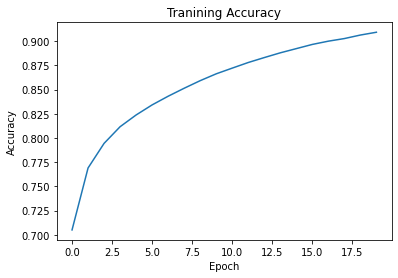

In [ ]:
plt.plot(r.history['accuracy'])
plt.title('Tranining Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

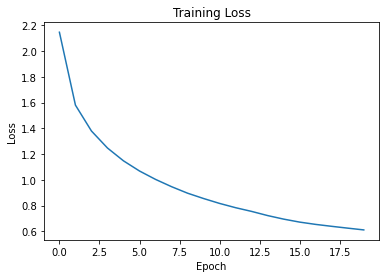

In [ ]:
plt.plot(r.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

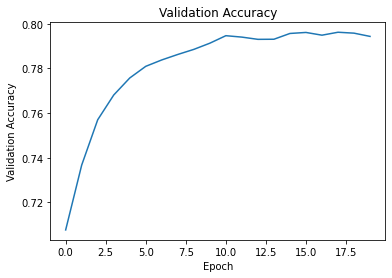

In [ ]:
plt.plot(r.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')

plt.show()

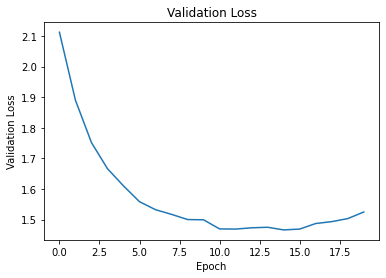

In [ ]:
plt.plot(r.history['val_loss'])
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')

plt.show()

In [ ]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [ ]:
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)


In [ ]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

In [ ]:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [ ]:
index_input_word = {v:k for k, v in input_word_index.items()}
index_target_word = {v:k for k, v in output_word_index.items()}

In [ ]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = output_word_index['<sos>']
    eos = output_word_index['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = index_target_word[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [ ]:
i = np.random.choice(len(Input_list))
input_seq = encoder_padded_input_sequence[i:i+1]
translation = translate_sentence(input_seq)

print('Randomly chosen input sentence:', Input_list[i])
print('Translated sentence:', translation)

Randomly chosen input sentence: I respected Tom.
Translated sentence: ich habe tom machte gegeben.
